In [2]:
#Importar librerias de Python
from ultralytics import YOLO
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import pickle
import cv2 
from PIL import Image
#Importar modulos de Util
import util.Reconstruction3d as Res3d
import util.MarkerAruco as MarkerAruco
import util.Depth_Anything_V2_Simple as Depth_Anything_V2_Simple 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


xFormers not available
xFormers not available


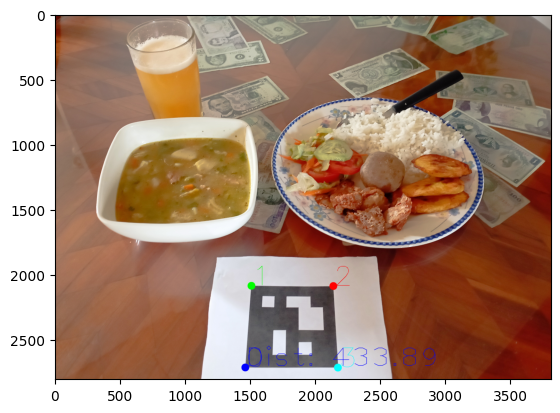

In [4]:
#Lectura de imagen
#"./content/Test_Images/IMG_20250202_122826.jpg"
img = cv2.cvtColor(cv2.imread("./content/Test_Images/IMG_20250202_122826.jpg"), cv2.COLOR_BGR2RGB) 

#Se cargar la configuracion de la camara
cameraMatrix = pickle.load(open("./calibration/cameraMatrix.pkl", "rb"))
dist = pickle.load(open("./calibration/dist.pkl", "rb"))

#Estimacion de parametros geometricos
parameter_Marker_geometry = MarkerAruco.geometry_estimation(img, 80.3, MarkerAruco.ARUCO_DICT["DICT_5x5_50"], cameraMatrix, dist)
#Eliminacion de distorsion en la imagen
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))
mapx, mapy = cv2.initUndistortRectifyMap(cameraMatrix, dist, None, newcameramtx, (w,h), 5)
img_dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
x, y, w, h = roi
img_dst= img_dst[y:y+h, x:x+w]
#Identificacion de Esquinas
parameter_Marker_corners = MarkerAruco.location_corners(img_dst, MarkerAruco.ARUCO_DICT["DICT_5x5_50"])
#Dibujamos las esquinas y mostramos distancia
img_marker = MarkerAruco.draw_parameter_detection(img_dst, parameter_Marker_geometry, parameter_Marker_corners)
#Vizualisamos resusltados
plt.imshow(img_marker)


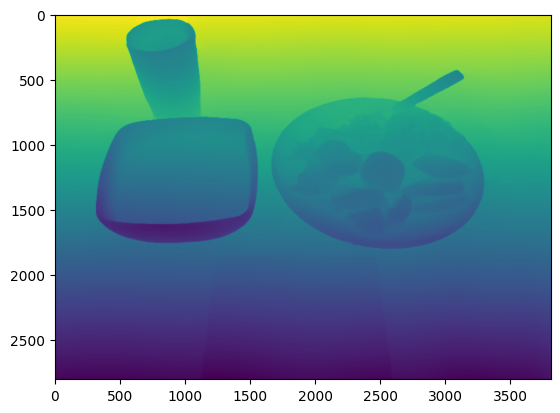

In [5]:
#Instancia del modelo Depth_Anything_V2
depthAythingV2 = Depth_Anything_V2_Simple.ModelDepthAnythingV2('vits',5) 
#Estimamos profundidar de la imagen
img_depth = depthAythingV2.predictionDepth(img_dst)
plt.imshow(img_depth)

In [14]:
# Distancia real conocida en mm
D_real = 111.6  
#Coordenadas u,v,w
u1,u2 = int(parameter_Marker_corners["top_left"][0]) , int(parameter_Marker_corners["bottom_right"][0])
v1,v2 = int(parameter_Marker_corners["top_left"][1]) , int(parameter_Marker_corners["bottom_right"][1])
w1 = img_depth[v1, u1]
w2 = img_depth[v2, u2]
#Calculo factor de escala
scale_factor = abs((D_real*np.sin(np.pi - parameter_Marker_geometry["theta_XY"])))/abs((w2 - w1))

#Paso de coordenadas relativa a absolutos del mapa de profundidad
image_depth_esc = img_depth*scale_factor #(mm)
image_depth_absolute = image_depth_esc - image_depth_esc[int(parameter_Marker_corners["top_left"][0]), int(parameter_Marker_corners["top_left"][1])] + parameter_Marker_geometry["distance"]
print(image_depth_absolute)


[[     645.53       645.8      646.08 ...      637.79      638.95       640.1]
 [     645.69       645.9       646.1 ...      637.24      638.21      639.18]
 [     645.85      645.99      646.12 ...       636.7      637.48      638.26]
 ...
 [     338.68      338.28      337.89 ...      344.31      344.33      344.35]
 [     339.58      339.02      338.46 ...      344.05      344.07       344.1]
 [     340.49      339.76      339.03 ...       343.8      343.82      343.84]]


In [6]:
#Instancia del modelo YOLO
model_segmentation = YOLO("./yolo/best.pt")
#Estimacion segmentacion
pred_segmentacion = model_segmentation(cv2.cvtColor(img_dst, cv2.COLOR_BGR2RGB))
# Obtener las máscaras detectadas
for result in pred_segmentacion:
    masks = result.masks.data.cpu().numpy()  


0: 480x640 1 wine, 1 juice, 1 chicken duck, 1 sauce, 1 tomato, 377.0ms
Speed: 15.0ms preprocess, 377.0ms inference, 38.0ms postprocess per image at shape (1, 3, 480, 640)


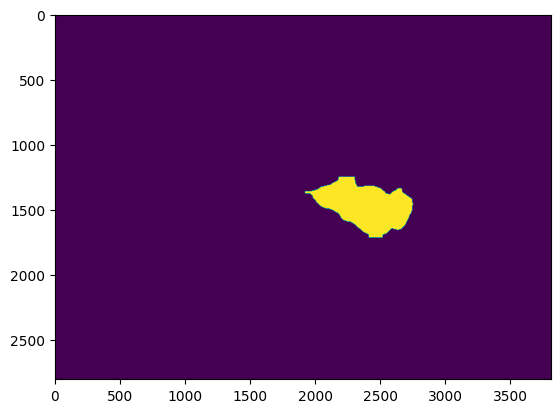

In [17]:
# Seleccionar una máscara específica
class_segmentation = 4
#Escalar mascara
width_dst, height_dst = int(np.shape(img_dst)[1]), int(np.shape(img_dst)[0])
resized_pred = cv2.resize(masks[class_segmentation],(width_dst, height_dst))
# Convertir a binario
resized_pred = (resized_pred > 0.5).astype(bool)
#mostrar mascara seleccionada
plt.imshow(resized_pred)

In [18]:
#Calculo volumen de la segmentacion
normal = - parameter_Marker_geometry["normal"]
volumen = Res3d.calculation_volumen(image_depth_absolute, resized_pred, normal, cameraMatrix)
print(f"Volumen Alimento: {round(volumen,2)} cm^3")

Volumen Alimento: 19.68 cm^3


In [16]:
#Creacion nube de puntos de la segmentacion
pcd = Res3d.depth_to_point_cloud_segmented(image_depth_absolute, resized_pred, normal, cameraMatrix)
#Visualizacion Nube de puntos segmentada
o3d.visualization.draw_geometries([pcd])


In [138]:
#Creacion nube de puntos de la escena
pcd_completed = Res3d.depth_to_point_cloud_scene(image_depth_absolute, img_dst, cameraMatrix)
o3d.visualization.draw_geometries([pcd_completed])
##################################################################################################################################################